<a href="https://colab.research.google.com/github/lhrkkk/LFP/blob/main/all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Settings


## Global Variables

In [1]:
### @title Global Variables {display-mode: "form"}

# 全局参数
# DATA_SOURCE='real'
DATA_SOURCE='synth'

SIMULATION_EVENTS=True
FIND_HIGHLIGHT=True
# SIMULATION_EVENTS=False
# FIND_HIGHLIGHT=False

# TFR 频率范围
fmin=5.
fmax=100.

# Event 窗口前后宽度
tmin=-0.5
tmax=0.5

# 聚类方法, Kmeans, TimeSeriesKmeans_DTW, DBSCAN, ward
# algorithm='kmeans'
algorithm='tsdtw'
# algorithm='dbscan'
# algorithm='ward'


## Workflow
1. 时频域图-》寻找高光活跃中心点-》将这些点，按频率划分到时间点集合

2. 对某一频率的时间点集，进行原始片段提取，并在此频率滤波后 -》普通聚类或 DTW距离聚类。

3. 返还到原信号时间片，对比类内样本的滤波后的波形。

这样能得到某一频率的活跃波形。并且能够按照相似性聚集类别。

In [2]:
#@title Dependences {display-mode: "form"}
# 加上这一行可折叠代码

# %%script false --no-raise-error  
# 加上这一行可以禁止 cell 运行

!pip install numpy matplotlib mne pandas PyWavelets scikit-learn tslearn yapf scipy imageio opencv-python numba dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
from matplotlib import pyplot as plt

from mne import create_info, Epochs
from mne.baseline import rescale
from mne.io import RawArray
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet,
                                tfr_array_morlet, AverageTFR)
from mne.viz import centers_to_edges
import scipy.stats as stats

from sklearn.cluster import AgglomerativeClustering 
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import linkage,dendrogram


from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import calinski_harabasz_score
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

from pprint import pprint

# from dtaidistance import dtw
# dist_dtai = dtw.distance_fast(a[0], a[1])

# parms = {
#     "quantile": 0.3,
#     "eps": 0.3,
#     "damping": 0.9,
#     "preference": -200,
#     "n_neighbors": 3,
#     "n_clusters": 3,
#     "min_samples": 7,
#     "xi": 0.05,
#     "min_cluster_size": 0.1,
# }
print(__doc__)


Automatically created module for IPython interactive environment


In [4]:
#@title Hepers {display-mode: "form"}

import sys
def var_from_name(name):
  return sys._getframe().f_back.f_locals[name]

# Source Data

In [5]:
#@title Real data {display-mode: "form"}

# %%script false --no-raise-error  # 真实信号
# 加上这一行可以禁止 cell 运行

if DATA_SOURCE=='real':

    ## 设定 Epoches 基本参数
    sfreq = 1250.0
    # ch_names = ['SIM0001', 'SIM0002']
    # ch_types = ['grad', 'grad']
    ch_names = ['LFP1']
    ch_types = ['seeg']  # 设定信号类型，会改变单位值
    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    epoch_real_time=10
    n_times = epoch_real_time*sfreq
    n_epochs = 40

    # real data
    import scipy.io as scio
    dataFile = 'VRlfp75.mat'

    data = scio.loadmat(dataFile)
    # channel0
    data=list(data['LFP_data']['lfp_ncs'][0][0].flatten())

    # 去掉末尾 0 值
    while data[-1]==0:
        del data[-1]

    # 标准化，其实不需要，MNE 会自动标准化
    data=np.array([data])
    data[0]=stats.zscore(data[0])

In [6]:
#@title Synth data {display-mode: "form"}

# %%script false --no-raise-error # 模拟信号

if DATA_SOURCE=='synth':

    ## 设定 Epoches 基本参数
    sfreq = 1000.0
    # ch_names = ['SIM0001', 'SIM0002']
    # ch_types = ['grad', 'grad']
    ch_names = ['SIM0001']
    ch_types = ['seeg']  # 设定信号类型，会改变单位值
    info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    n_times = 4024  # Just over 1 second epochs
    n_epochs = 1

    seed = 42
    rng = np.random.RandomState(seed)
    data = rng.randn(len(ch_names), n_times * n_epochs + 200)  # buffer

    # Add a 50 Hz sinusoidal burst to the noise and ramp it.  加入50Hz的正弦脉冲
    t = np.arange(n_times, dtype=np.float64) / sfreq
    signal = 10*np.sin(np.pi * 2. * 50. * t)  # 50 Hz sinusoid signal
    # print(signal)
    signal[np.logical_or(t < 0.45, t > 0.55)] = 0.  # Hard windowing
    on_time = np.logical_and(t >= 0.45, t <= 0.55)
    # print(on_time)
    signal[on_time] *= np.hanning(on_time.sum())  # Ramping
    data[:, 100:-100] += np.tile(signal, n_epochs)  # add signal
data

array([[ 0.49671415, -0.1382643 ,  0.64768854, ...,  0.84477438,
        -0.00556029,  1.17851269]])

In [7]:
# 读取 data 数据到 raw 变量，进入 MNE 处理流程
raw = RawArray(data, info)

Creating RawArray with float64 data, n_channels=1, n_times=4224
    Range : 0 ... 4223 =      0.000 ...     4.223 secs
Ready.


In [8]:
#@title %(bandpass filter) {display-mode: "form"}
# bandpass filter
# fmin=0
# fmax=60
# raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
#                l_trans_bandwidth=1,  # make sure filter params are the same
#                h_trans_bandwidth=1)  # in each band and skip "auto" option.

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


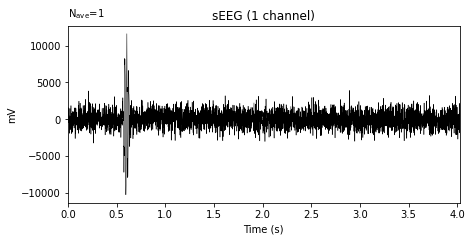

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 1 events and 4025 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Need more than one channel to make topography for seeg. Disabling interactivity.
1


<ipython-input-9-89af1e60879b>:22: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


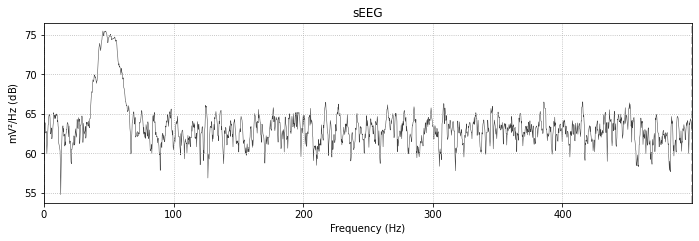

In [9]:
# %%script false --no-raise-error  # 模拟信号生成 Events 和 Epoches

if DATA_SOURCE=='synth':

    # event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
    # events 是一系列 event 的列向量
    events = np.zeros((n_epochs, 3), dtype=int)
    events[:, 0] = np.arange(n_epochs) * n_times

    # epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
    # epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
    epochs = Epochs(raw, events, dict(sin50hz=0), tmin=0, tmax=n_times / sfreq,
                    reject=dict(seeg=4000), 
                    baseline=None)


    # 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
    # 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
    epochs.average().plot()

    # 可以画出频率谱看一下
    epochs.plot_psd()
    # for i in range(n_epochs):
        # epochs[i].average().plot()

    # print(events)
# print(events)
print(n_epochs)


In [10]:
#%%script false --no-raise-error # 真实信号生成 Events 和 Epoches

if DATA_SOURCE=='real':

  # event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
  # events 是一系列 event 的列向量
  events = np.zeros((n_epochs, 3), dtype=int)
  events[:, 0] = np.arange(n_epochs) * n_times

  # epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
  # epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
  epochs = Epochs(raw, events, 0, tmin=0, tmax=n_times / sfreq,
                  # reject=dict(seeg=4000), 
                  baseline=None)


  # 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
  # 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
  epochs.average().plot()
  # 可以画出频率谱看一下
  epochs.plot_psd()
  # for i in range(n_epochs):
      # epochs[i].average().plot()



# Simulate Waveform Signals
需要提取 n_types 类型个数，以及混入的波包数量。

信号时长较长的时候，TFR 会解析度会非常细。无法读出结果。下述解决方案可能有用：

### 时频图分辨率
图片要注意时间轴的分辨率和横纵轴的比例。
可以让复杂度不线性增长，比如开根号或者取对数决定总长，然后再线性缩放。
也许配合小波分辨率 freqs/x 来获得最佳解析。


ampltiude, freq, phase:
[[[ 6.00000000e+00  4.50000000e+01  4.81801546e-01]
  [ 6.00000000e+00  3.50000000e+01 -3.63915466e-01]
  [ 6.00000000e+00  2.80000000e+01 -9.74568320e-01]
  [ 1.00000000e+01  8.50000000e+01 -7.50714327e-01]
  [ 2.00000000e+00  5.90000000e+01 -4.56168251e-01]]

 [[ 3.00000000e+00  2.20000000e+01  3.74907506e-01]
  [ 8.00000000e+00  2.50000000e+01  2.80460556e-01]
  [ 7.00000000e+00  9.90000000e+01 -1.32169648e-01]
  [ 9.00000000e+00  8.20000000e+01  2.44042689e-01]
  [ 1.00000000e+01  5.40000000e+01 -6.98847722e-02]]]
Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


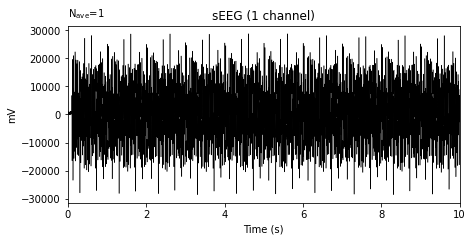

Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


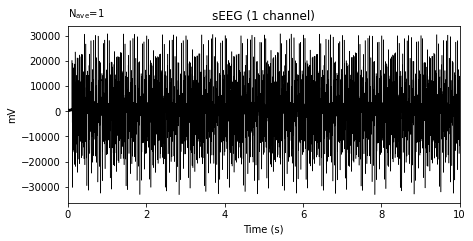

inserted waves:
{0: [1.479, 3.165, 4.628, 8.245000000000001, 9.248000000000001],
 1: [0.74, 2.388, 5.3549999999999995, 6.697, 7.538]}
Creating RawArray with float64 data, n_channels=1, n_times=10200
    Range : 0 ... 10199 =      0.000 ...    10.199 secs
Ready.
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


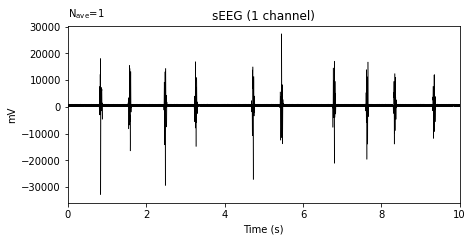

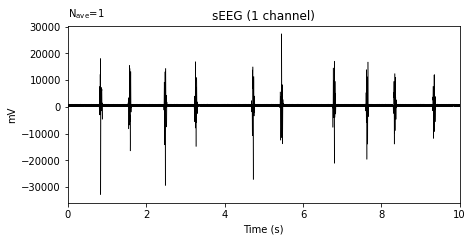

In [11]:
## 设定 Epoches 基本参数
sfreq = 1000.0 #1s的采样点数目
all_time = 12 #采样秒数
# ch_names = ['SIM0001', 'SIM0002']
# ch_types = ['grad', 'grad']
ch_names = ['SIM0001']
ch_types = ['seeg']  # 设定信号类型，会改变单位值
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
n_times = sfreq*all_time  # Just over 1 epochs 一个epochs的采样数目 10S
n_epochs = 1 #epochs数目

N_wave_types=2  # 波形种类
N_sin_types=3   # 每个波形内部的 sin 个数

n_wave = 10     # 插入波片段的数量
max_time_len = 0.1 #插入信号最长的长度s
min_time_len = 0.1 #插入信号最短长度
intervel = 0.6

ampltiude_range = [1,10]
freq_range = [20,100]
phase_range = [-1,1]  # sin(2pi(wt+phi))




# ========== testing ===============
## 设定 Epoches 基本参数
sfreq = 1000.0 #1s的采样点数目
all_time = 10 #采样秒数
ch_names = ['synthesized']
ch_types = ['seeg']  # 设定信号类型，会改变单位值
info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
n_times = sfreq*all_time  # Just over 1 epochs 一个epochs的采样数目 10S
n_epochs = 1 #epochs数目

N_wave_types=2  # 波形种类
N_sin_types=5   # 每个波形内部的 sin 个数

n_wave = 10     # 插入波片段的数量
max_time_len = 0.1 #插入信号最长的长度s
min_time_len = 0.1 #插入信号最短长度
intervel = 0.6

ampltiude_range = [1,10]
freq_range = [20,100]
phase_range = [-1,1]  # sin(2pi(wt+phi))
# =========================


import random
#生成sin的种类参数
sin_parameters = np.zeros((N_wave_types,N_sin_types,3)) #三个种类波的参数 [[[振幅，频率，相位],[振幅，频率，相位],[振幅，频率，相位]]]

for wave_type in range(N_wave_types):
    for sin_type in range(N_sin_types):
        sample_type = np.array([random.randint(ampltiude_range[0], ampltiude_range[1]), random.randint(freq_range[0], freq_range[1]), random.uniform(phase_range[0], phase_range[1])])
        sin_parameters[wave_type][sin_type] = sample_type
print('ampltiude, freq, phase:')
print(sin_parameters)

#生成信号
import time
import datetime
seed = int(time.time())
rng = np.random.RandomState(seed)
# data = rng.randn(len(ch_names), int(n_times) * n_epochs)  # 正态分布的背景buffer
data = rng.rand(len(ch_names), int(n_times) * n_epochs + 200)  # 正态分布的背景buffer

t = np.arange(n_times, dtype=np.float64) / sfreq


# 生成信号插入位置
locs_all = np.arange(n_times, dtype=np.float64) 
locs=[]
for i in range(n_wave):
    success=False
    while not success:
        loc=int(np.random.rand()*n_times)
        end=int(loc+(max_time_len+intervel)*sfreq)
        if end<n_times and locs_all[loc] != -1 and locs_all[end] != -1:
            for tmp_index in range(loc, end):
                locs_all[tmp_index]=-1
            success=True
            locs.append(loc/sfreq)               
locs=sorted(locs)

# locs = sorted(np.random.rand(n_wave+1)*all_time)
# while len([i for index,i in enumerate(locs) if index>0 and i-locs[index-1]>=max_time_len+intervel])<n_wave:
# #     print(len([i for index,i in enumerate(locs) if index>0 and i-locs[index-1]>=min_time_len]))
#     locs = sorted(np.random.rand(n_wave+1)*all_time)
import math
def print_res(res_type):
    data_tmp = rng.rand(len(ch_names), int(n_times) * n_epochs + 200)  # 正态分布的背景buffer
    data_tmp[:, 100:-100] += np.tile(res_type, n_epochs)  # add signal np.tile扩展数组  从第100个采样点开始
    raw_tmp = RawArray(data_tmp, info)
    events_tmp = np.zeros((n_epochs, 3), dtype=int)
    events_tmp[:, 0] = np.arange(n_epochs) * n_times
    epochs_tmp = Epochs(raw_tmp, events_tmp, dict(sin50hz=0), tmin=0, tmax=n_times / sfreq,
                    reject=dict(seeg=4000), 
                    baseline=None)
    epochs_tmp.average().plot()


# 生成波包类型列表 wave_types, 并在随机位置混入
t = np.arange(n_times, dtype=np.float64) / sfreq
final_signal = np.zeros(int(n_times))

res_types=[]
for i in range(N_wave_types):
    type_parameters = sin_parameters[i]
    res_type = np.zeros(int(n_times))
    for parameter in  type_parameters:
        res_type += parameter[0]*np.sin(np.pi * 2. * (parameter[1] * t + parameter[2]))
    res_types.append(res_type)
    print_res(res_type)



def select_wave():
    r=np.random.rand()
    n=math.floor(r*N_wave_types)
    if n==N_wave_types:
        n=n-1
    return n

inserted_waves={}
for begin in locs:
    selected_wave=select_wave()
    res_type=res_types[selected_wave]
    signal = res_type.copy()
    # 波形不变，但是长度变化
    wave_len = random.uniform(min_time_len, max_time_len)
    end = begin+wave_len
    signal[np.logical_or(t <begin, t >end )] = 0.
    on_time = np.logical_and(t >=  begin, t <= end)
    # 最后截取到的相位是不同的，同一个样本不同位置的波包相位不同。因此合成振幅也不同
    signal[on_time] *= np.hanning(on_time.sum())  # Ramping
    final_signal += signal
    if selected_wave in inserted_waves:
        inserted_waves[selected_wave].append((begin+end)/2)
    else:
        inserted_waves[selected_wave]=[]
        inserted_waves[selected_wave].append((begin+end)/2)
print('inserted waves:')
pprint(inserted_waves)

data[:, 100:-100] += np.tile(final_signal, n_epochs)  # add signal np.tile扩展数组  从第100个采样点开始

# 读取 data 数据到 raw 变量，进入 MNE 处理流程
raw = RawArray(data, info)
# 模拟信号生成 Events 和 Epoches
# event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
# events 是一系列 event 的列向量
events = np.zeros((n_epochs, 3), dtype=int)
events[:, 0] = np.arange(n_epochs) * n_times

# epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
# epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
epochs = Epochs(raw, events, dict(sin50hz=0), tmin=0, tmax=n_times / sfreq,
                reject=dict(seeg=4000), 
                baseline=None)


# 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
# 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
epochs.average().plot()

# Draw TFR

Using data from preloaded Raw for 1 events and 10001 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


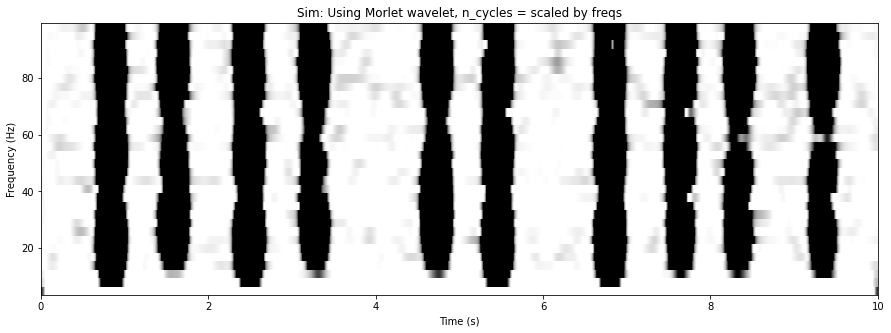

In [12]:
# %%script false --no-raise-error  # 画时频图，一张
fmin=5.
fmax=100.
freqs = np.arange(fmin, fmax, 3.)
# print(freqs)
vmin, vmax = 0, 3.  # Define our color limits.

fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
# all_n_cycles = [1, 3, freqs / 2.]
# all_n_cycles = [freqs / 2.,freqs / 2.,freqs / 3.,freqs / 4.,freqs / 5.,]
all_n_cycles = [freqs / 2.]
# print(all_n_cycles)
# print(axs)

for n_cycles, ax in zip(all_n_cycles, [axs]):
    power = tfr_morlet(epochs, freqs=freqs,
                       n_cycles=n_cycles, return_itc=False,
                    #    average=False
                       )
    power.plot([0], baseline=(0., 0.1), mode='mean', vmin=vmin, vmax=vmax,
               axes=ax, show=False, colorbar=False,
               cmap='binary'
               )
    n_cycles = 'scaled by freqs' if not isinstance(n_cycles, int) else n_cycles
    ax.set_title(f'Sim: Using Morlet wavelet, n_cycles = {n_cycles}')

# from IPython.core.pylabtools import figsize # import figsize
# figsize(4, 4) # 设置 figsize

# plt.figure(figsize=(4., 4.))
# plt.figure(dpi=300)
# plt.tight_layout()


# all_n_cycles
plt.savefig('output.png',dpi=10*all_time)

# Find Hightlights

In [13]:
#@title Functions: Define find highlights functions{display-mode: "form"}
# 定义寻找高光点的函数，内有参数可调。
# find highlight
import scipy.ndimage as ndimg
import numpy as np
from numba import jit
import cv2

def neighbors(shape):
    dim = len(shape)
    block = np.ones([3] * dim)
    block[tuple([1] * dim)] = 0
    idx = np.where(block > 0)
    idx = np.array(idx, dtype=np.uint8).T
    idx = np.array(idx - [1] * dim)
    acc = np.cumprod((1,) + shape[::-1][:-1])
    return np.dot(idx, acc[::-1])


@jit  # trans index to r, c...

def idx2rc(idx, acc):
    rst = np.zeros((len(idx), len(acc)), dtype=np.int16)
    for i in range(len(idx)):
        for j in range(len(acc)):
            rst[i, j] = idx[i] // acc[j]
            idx[i] -= rst[i, j] * acc[j]
    return rst


#@jit  # fill a node (may be two or more points)

def fill(img, msk, p, nbs, buf):
    msk[p] = 3
    buf[0] = p
    back = img[p]
    cur = 0
    s = 1
    while cur < s:
        p = buf[cur]
        for dp in nbs:
            cp = p + dp
            if img[cp] == back and msk[cp] == 1:
                msk[cp] = 3
                buf[s] = cp
                s += 1
                if s == len(buf):
                    buf[:s - cur] = buf[cur:]
                    s -= cur
                    cur = 0
        cur += 1
    #msk[p] = 3


#@jit  # my mark

def mark(img, msk, buf, mode):  # mark the array use (0, 1, 2)
    omark = msk
    nbs = neighbors(img.shape)
    idx = np.zeros(1024 * 128, dtype=np.int64)
    img = img.ravel()  # 降维
    msk = msk.ravel()  # 降维
    s = 0
    for p in range(len(img)):
        if msk[p] != 1: continue
        flag = False
        for dp in nbs:
            if mode and img[p + dp] > img[p]:
                flag = True
                break
            elif not mode and img[p + dp] < img[p]:
                flag = True
                break

        if flag : continue
        else    : fill(img, msk, p, nbs, buf)
        idx[s] = p
        s += 1
        if s == len(idx): break
    plt.imshow(omark, cmap='gray')
    return idx[:s].copy()



def filter(img, msk, idx, bur, tor, mode):
    omark = msk
    nbs = neighbors(img.shape)
    acc = np.cumprod((1,) + img.shape[::-1][:-1])[::-1]
    img = img.ravel()
    msk = msk.ravel()

    arg = np.argsort(img[idx])[::-1 if mode else 1]

    for i in arg:
        if msk[idx[i]] != 3:
            idx[i] = 0
            continue
        cur = 0
        s = 1
        bur[0] = idx[i]
        while cur < s:
            p = bur[cur]
            if msk[p] == 2:
                idx[i] = 0
                break

            for dp in nbs:
                cp = p + dp
                if msk[cp] == 0 or cp == idx[i] or msk[cp] == 4: continue
                if mode and img[cp] < img[idx[i]] - tor: continue
                if not mode and img[cp] > img[idx[i]] + tor: continue
                bur[s] = cp
                s += 1
                if s == 1024 * 128:
                    cut = cur // 2
                    msk[bur[:cut]] = 2
                    bur[:s - cut] = bur[cut:]
                    cur -= cut
                    s -= cut

                if msk[cp] != 2: msk[cp] = 4
            cur += 1
        msk[bur[:s]] = 2
        #plt.imshow(omark, cmap='gray')

    return idx2rc(idx[idx > 0], acc)


def find_maximum(img, tor, mode=True):
    msk = np.zeros_like(img, dtype=np.uint8)
    msk[tuple([slice(1, -1)] * img.ndim)] = 1
    buf = np.zeros(1024 * 128, dtype=np.int64)
    omark = msk
    idx = mark(img, msk, buf, mode)
    plt.imshow(msk, cmap='gray')
    idx = filter(img, msk, idx, buf, tor, mode)
    return idx

# 寻找坐标框
def getBigestTriangle(img):
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)  #寻找轮廓点
    bigest_loc = []
    bigest_area = 0
    for obj in contours:
        area = cv2.contourArea(obj)  #计算轮廓内区域的面积
        perimeter = cv2.arcLength(obj,True)  #计算轮廓周长
        approx = cv2.approxPolyDP(obj,0.02*perimeter,True)  #获取轮廓角点坐标
        CornerNum = len(approx)   #轮廓角点的数量
        if area>bigest_area:
            bigest_area = area
            bigest_loc = approx
    if bigest_area>0:
#         return img[loc1[0][1]:loc2[0][1],loc1[0][0]:loc2[0][0]]
        return bigest_loc
    else:
        return None
def downsample(image, scalex,scaley):
    w = int(image.shape[1] / scalex)
    h = int(image.shape[0] / scaley)
    image = cv2.pyrDown(image, dstsize=(w,h))
    return image

# 寻找高光点主函数
def find_highlight(filepath):
 # from scipy.misc import imread
    from imageio import imread
    from scipy.ndimage import gaussian_filter
    from time import time
    import matplotlib.pyplot as plt

    img = cv2.imread(filepath)
    # img = downsample(img,2,2)
    imgContour = img.copy()
    imgGray = cv2.cvtColor(imgContour,cv2.COLOR_RGB2GRAY)  #转灰度图
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)  #高斯模糊
    imgCanny = cv2.Canny(imgBlur,60,60)  #Canny算子边缘检测
    locs = getBigestTriangle(imgCanny)  #坐标框
    locs = locs.reshape(locs.shape[0],-1)
    tem = sorted(locs,key = lambda x:x[1])
    tem = [x for x in tem if x[1]<tem[0][1]+5]
    tem = sorted(tem, key=lambda x:x[0]+x[1])
    left_up = tem[0]
    tem1 = sorted(locs,key = lambda x:x[0],reverse=True)
    tem1 = [x for x in tem1 if x[0]>tem1[0][0]-5]
    tem1 = sorted(tem1, key=lambda x:x[0]+x[1], reverse=True)
    right_down = tem1[0]
    img = img[left_up[1]:right_down[1],left_up[0]:right_down[0]]
    print(left_up,right_down)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.bitwise_not(img) # invert color
    ret2, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img[:] = ndimg.distance_transform_edt(img)
    plt.imshow(img, cmap='gray')
    start = time()
    pts = find_maximum(img, 9, True)  ######### 这个参数可调识别阈值
    print(time() - start)
    print(pts)
    plt.imshow(img, cmap='gray')
    plt.plot(pts[:, 1], pts[:, 0], 'y.')
    plt.show()
    return img,pts

## Find Highlight

[187  60] [1351  443]
24.99052906036377
[[  36  970]
 [  52  381]
 [  52 1088]
 [  55  184]
 [  64  550]
 [ 162  791]
 [ 170  889]
 [ 246  549]
 [ 270  380]
 [ 274  970]
 [ 279 1086]
 [ 289   98]
 [ 292  290]
 [ 305  634]]


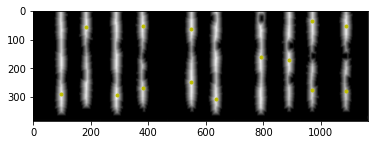

[[91.07049608  8.33333333]
 [87.10182768  3.27319588]
 [87.10182768  9.34707904]
 [86.35770235  1.58075601]
 [84.12532637  4.72508591]
 [59.81723238  6.79553265]
 [57.83289817  7.63745704]
 [38.98172324  4.71649485]
 [33.02872063  3.26460481]
 [32.03655352  8.33333333]
 [30.79634465  9.32989691]
 [28.31592689  0.8419244 ]
 [27.57180157  2.49140893]
 [24.34725849  5.4467354 ]]
14
(383, 1164)


10.0

In [14]:
# %%script false --no-raise-error
# if FIND_HIGHLIGHT==True:
if 1:
  # find_highlight('output.png')
    img,pts =  find_highlight('output.png')
    original_loc = []
    orignal_scale = [fmax-fmin, n_times / sfreq]
    for pt in pts:
        original_loc.append(pt/img.shape*orignal_scale)
    original_loc = np.array(original_loc)
    original_loc[:,0] = fmax - original_loc[:,0]  #因为处理完后的纵坐标是倒着的
print(original_loc)
print(len(original_loc))
# print(pts)

print(img.shape)
n_times / sfreq

## Generate Events

In [15]:
#@title Clustering same frequency and generate lists for events {display-mode: "form"}

# done。但是 kmeans 聚类总是出现样本太少的问题。前面图片处理有 bug，有时候会图片没处理完就结束了

# print(original_loc)
source=original_loc[:,0].reshape(-1,1)
# print(source)
kmeans = KMeans(n_clusters=3, random_state=666)
y_pre = kmeans.fit_predict(source)
# print(y_pre)
type_id=np.unique(y_pre)
freqs_times=[]
type_freq_range=[]
for lab_id, lab in enumerate(type_id):
    times=[]
    for sample_id, samp in enumerate(source):
        if y_pre[sample_id] == lab_id:
            print(source[sample_id])
            times.append(original_loc[sample_id,1]*sfreq)
    freqs_times.append(times)
print(freqs_times)
# freqs_times=np.array(freqs_times)
# nSample, nDim = source.shape
# labs=type_id
# means = np.zeros((len(labs),nDim))
# for i, lab in enumerate(labs):
#     means[i] = np.mean(source[y_pre == lab], axis=0)
# Muk=means  # 聚类中心
Muk = kmeans.cluster_centers_  # 聚类中心
print(Muk)

freq_width=5
type_freq_range=list(map(lambda x: [x[0]-freq_width,x[0]+freq_width], Muk))
print(type_freq_range)

[38.98172324]
[33.02872063]
[32.03655352]
[30.79634465]
[28.31592689]
[27.57180157]
[24.34725849]
[91.07049608]
[87.10182768]
[87.10182768]
[86.35770235]
[84.12532637]
[59.81723238]
[57.83289817]
[[4716.494845360825, 3264.6048109965636, 8333.333333333334, 9329.896907216495, 841.9243986254297, 2491.408934707904, 5446.735395189003], [8333.333333333334, 3273.1958762886597, 9347.079037800688, 1580.7560137457044, 4725.0859106529215], [6795.532646048111, 7637.457044673539]]
[[30.72547557]
 [87.15143603]
 [58.82506527]]
[[25.72547556881761, 35.725475568817615], [82.1514360313316, 92.1514360313316], [53.825065274151434, 63.825065274151434]]


In [16]:
%%script false --no-raise-error  

#@title %simulate test {display-mode: "form"}
# 加上这一行可折叠代码

# 加上这一行可以禁止 cell 运行
# package found highlights to Events
if SIMULATION_EVENTS==False:

    type_freq_range=[[40,45],[50,60],[60,80]]  # 单位 Hz
    freqs_times=np.array([[3,4,5,],[9,10,11],[6,7,8]])*sfreq  # 单位 s
    type_id=[0,1,2]

print('enabled')

In [17]:
%%script false --no-raise-error  
# 加上这一行可以禁止 cell 运行
#@title %simulate test {display-mode: "form"}

# simulation events
if SIMULATION_EVENTS==True:
    times=np.array([1.5,2.5,40,50,60,70,80,90,100]) # 单位 s
    sample_times=times*sfreq #换算成 sample
    n_epochs=len(times)

    # event 是一个三元组(first_sample, ,event_code), 标记一个事件的（该事件起始时间采样点，，事件类型编号）
    # events 是一系列 event 的列向量
    events = np.zeros((n_epochs, 3), dtype=int)
    events[:, 0] = sample_times
    # events
# epoch 是根据 event 截取的片段，其中 tmin，tmax 是 first_sample 前后的偏移量
# epoches 是一系列 epoch，也就是一系列事件截取的等长片段集合
epochs = Epochs(raw, events, 0, tmin=-1, tmax=1,
                # reject=dict(seeg=4000), 
                baseline=None)


# 这里是对所有 epoches 取平均，模拟信号生成的时候是每个 epoch 中 event 是相同的，所以能够很好的平均。平均用于去掉噪声。
# 但是如果是我们自己的真实信号，由于没有 event 的数据，平均会乱掉，所以不用平均，也不用切那么小的片段。
# epochs.average().plot()
# epochs.plot_psd()
# epochs.plot_image()


# Clustering Events

In [18]:
#@title custom metric {display-mode: "form"}

def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [19]:
#@title %(bandpass filter) {display-mode: "form"}
# bandpass filter
# fmin=0
# fmax=60
# raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
#                l_trans_bandwidth=1,  # make sure filter params are the same
#                h_trans_bandwidth=1)  # in each band and skip "auto" option.

## Pipeline

In [20]:
from scipy import signal

def butter_bandpass(cut_off_frequency_list, order=5):
    ''' 带通滤波器，需要两个截止频率，以 list 形式输入 '''
    nyq = 0.5 * sfreq
    normal_cut_off = np.array(cut_off_frequency_list) / nyq
    b, a = signal.butter(order, normal_cut_off,
                  btype="bandpass", analog=False)
    return b, a

def butter_bandpass_filtfilt(cut_off_frequency_list,data, order=5):
    ''' 带通滤波器的执行，消除延迟 '''
    b, a = butter_bandpass(cut_off_frequency_list, order=order)
    y = signal.filtfilt(b, a, data)
    return y


def bandpass(freq_band_list):
    def bp(source):
        _source=source.copy()
        new_source=[]
        for i,_ in enumerate(_source):
            new_source.append(butter_bandpass_filtfilt(freq_band_list,_source[i]))
        return new_source
    return bp

def zscore(source):
    _source=source.copy()
    new_source=[]
    for i,_ in enumerate(_source):
        new_source.append(stats.zscore(_source[i]))
    return new_source

def downsample(downscale):
    def ds(source):
        _source=source.copy()
        new_source=[]
        for i,_ in enumerate(_source):
            new_source.append(_source[i][::downscale])
        return new_source
    return ds

def pipeline(func_list):
    def pipe(source):
        _source=source.copy()
        for i in func_list:
            _source=i(_source)
        return np.array(_source)
    return pipe





### %more filters


In [21]:
%%script false --no-raise-error  
# 加上这一行可以禁止 cell 运行

#@title raw filter {display-mode: "form"}
# 加上这一行可折叠代码

def make_seg_epochs(seg):
    data2=[seg.copy()]
    raw = RawArray(data2, info)
    # print(raw.get_data())
    n_epochs=1
    n_times=len(seg)
    # print(n_times)
    events = np.zeros((n_epochs, 3), dtype=int)
    events[:, 0] = 0
    # print(events)
    epochs = Epochs(raw, events, tmin=0, tmax=(n_times-50) / sfreq,
                    # reject=dict(seeg=4000),
                    baseline=None)
    # print(epochs.get_data())
    fmin=45
    fmax=55
    raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
                l_trans_bandwidth=1,  # make sure filter params are the same
                h_trans_bandwidth=1)  # in each band and skip "auto" option.

    epochs.average().plot()
    epochs.plot_psd()
    return raw.get_data()[0]
seg_psd(data[0])
d=data[0].copy()
d=make_seg_epochs(d)
# print(d)
seg_psd(d)

In [22]:
%%script false --no-raise-error  
# 加上这一行可以禁止 cell 运行

#@title butterworth filter {display-mode: "form"}
# 加上这一行可折叠代码

print(data[0])
def seg_psd(seg):
    data2=[seg.copy()]
    raw = RawArray(data2, info)
    print(raw.get_data())
    n_epochs=1
    n_times=len(seg)
    print(n_times)
    events = np.zeros((n_epochs, 3), dtype=int)
    events[:, 0] = 0
    print(events)
    epochs = Epochs(raw, events, tmin=0, tmax=(n_times-50) / sfreq,
                    # reject=dict(seeg=4000),
                    baseline=None)
    # print(epochs.get_data())
    epochs.average().plot()
    epochs.plot_psd()

seg_psd(data[0])
d=data[0].copy()
d=butter_bandpass_filtfilt([45,55],d)
print(d)
seg_psd(d)

## Model fit

In [23]:
def add1(a):
    return a+2
add1(epochs.get_data())


Using data from preloaded Raw for 1 events and 10001 original time points ...


array([[[2.9378027 , 2.01147344, 2.45236323, ..., 2.96658567,
         2.42549473, 2.81661252]]])

In [24]:

def clustering(ievents,algorithm,pipeline=pipeline([])):
    epochs = Epochs(raw, ievents, ievents[0][2], tmin=tmin, tmax=tmax,baseline=None)
    source=epochs.get_data()[:,0] # 原始信号  
    # print(ievents)
    _source=source   # 保存原始信号
    p_source=pipeline(_source)  # 保存新信号
    source=p_source   # 用新的拷贝管道信号
    # 总是用 p 信号聚类。如果不想要管道，输入的时候就设置 pipeline

    best_score = 0
    best_pre = []
    best_cluster_num = 0
    # print('========len',len(source))
    kmax=min(len(source),10)
    # tskmax=max(round(kmax/2),2) #减少 ts 最大类数以减少运行时间
    tskmax=kmax
    best_model=0
    if algorithm == 'kmeans':
        # for index, k in enumerate((2,3)):
        for k in range(2,kmax):
            # 选择模型, 默认 Kmeans
            # TimeSeriesKmeans_DTW, DBSCAN, ward, Kmeans
            # model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
            model=KMeans(n_clusters=k, random_state=666)
            y_pre = model.fit_predict(source)
            print(f'y_pre: {y_pre}')
            # score = calinski_harabasz_score(source, y_pre)
            score = silhouette_score(source, y_pre)
            print(f'score: {score}')
            if score > best_score:
                best_score = score
                best_pre = y_pre
                best_cluster_num = k
                best_model=model
    elif algorithm == 'tsdtw':
        # for index, k in enumerate((2,3,4,5,6,7)):
        for k in range(2,kmax):
            model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
            y_pre = model.fit_predict(source)
            print(f'y_pre: {y_pre}')
            score = silhouette_score(source, y_pre,metric="dtw")
            # score = calinski_harabasz_score(source, y_pre)
            print(f'score: {score}')
            if score > best_score:
                best_score = score
                best_pre = y_pre
                best_cluster_num = k
                best_model=model
    elif algorithm == 'dbscan':
        # model = DBSCAN(eps=14, min_samples=2, metric=lambda a, b: DTW(a, b))
        model = DBSCAN(eps=0.3, min_samples=3)
        y_pre = model.fit_predict(source)
        print(f'y_pre: {y_pre}')
        # score = calinski_harabasz_score(source, y_pre)
        score = silhouette_score(source, y_pre)

        print(f'score: {score}')
        if score > best_score:
            best_score = score
            best_pre = y_pre
            best_model=model
    elif algorithm == 'ward':
        model = AgglomerativeClustering(n_clusters = k, linkage = 'ward', metric=DTW)
        y_pre = model.fit_predict(source)
        print(f'y_pre: {y_pre}')
        score = calinski_harabasz_score(source, y_pre)
        print(f'score: {score}')
        if score > best_score:
            best_score = score
            best_pre = y_pre
            best_model=model

    print(f'best_score: {best_score}')
    print(f'best_model: {best_model}')
    print(f'best_cluster_num: {best_cluster_num}')

    source=_source # 取回原始信号, source 默认为原信号，p_source 为拷贝管道后的信号
    model_ans={}
    for i in ('epochs','ievents','source','p_source','best_model','best_pre','best_score'):
        model_ans.update({i:var_from_name(i)})
    return  model_ans
  # model_ans=dict(
  #     best_model=best_model,
  #     best_pre=best_pre,
  #     best_score=best_score,
  #     best_cluster_num=best_cluster_num
  # )



# Ploting 

In [25]:
#@title Function: Print segment by sample location {display-mode: "form"}

# 根据 sample 位置打印前后片段
def print_sample(first_sample):
    _events = np.zeros((1, 3), dtype=int)
    _events[:, 0] = [first_sample]
    _epochs = Epochs(raw, _events, 0, tmin=tmin, tmax=tmax,
                # reject=dict(seeg=4000), 
                baseline=None)
    # epochs.average().plot(title=str(first_sample))
    try:
        _epochs.average().plot(titles='segment at sample: '+str(first_sample))
    except:
        print(f'====！！ Segment at sample {first_sample} may overcutted range of length')

## Plot Clusters

In [32]:
# Muk = best_model.cluster_centers_  # 聚类中心
# C_i = best_model.predict(source)   # 类别列表


def plot_p_clusters(ans):
    ans=ans.copy()
    print('****************************************')
    print('*** Ploting Clusters after pipeline : **')
    print('****************************************')

    ans['source']=ans['p_source']
    plot_clusters(ans)

def plot_clusters(ans):
    nSample, nDim = ans['source'].shape
    labs = np.unique(ans['best_pre'])
    means = np.zeros((len(labs),nDim))
    for i, lab in enumerate(labs):
        means[i] = np.mean(ans['source'][ans['best_pre'] == lab], axis=0)
    Muk=means  # 聚类中心
    # print(ans['best_model'])
    if hasattr(ans['best_model'], "labels_"):
        y_pred = ans['best_model'].labels_.astype(int)
    else:
        y_pred = ans['best_model'].predict(X)
    C_i = y_pred  # 类别列表
    # print('Events location:')
    # print(ans['ievents'])

    print('================================')
    print('==   Ploting Clusters :       ==')
    print('================================')


    # 多次循环
    for index, (center,lab) in enumerate(zip(Muk,np.unique(C_i))):
        plt.subplot(Muk.shape[0], 1, index+1)
        for original_index, point in enumerate(ans['source']):
            if C_i[original_index] == lab:
                print('label =',lab,', sample location:',ans['ievents'][original_index][0], ',' , ans['ievents'][original_index][0]/sfreq,'s,', 'segment_head:', point[:3],'original_index:', original_index)
                plt.plot(np.arange(point.size),point)   # 绘制类内 sample
    plt.plot(np.arange(center.size),center,color='red' )   # 绘制聚类中心
    plt.show()

    # 打印原始原始片段
    print('================================')
    print('= Printing Oringinal Segments: =')
    print('================================')
    for index, (center,lab) in enumerate(zip(Muk,np.unique(C_i))):
        print(f'--------  label = {lab}  --------')
        for original_index, point in enumerate(ans['source']):
            if C_i[original_index] == lab:
                print('label =',lab,', sample location:',ans['ievents'][original_index][0], ',' , ans['ievents'][original_index][0]/sfreq,'s,', 'segment_head:', point[:3],'original_index:', original_index)
                print_sample(ans['ievents'][original_index][0])

    # for original_index,(point,lab) in enumerate(zip(ans['source'],C_i)):
        # print_sample(ans['ievents'][original_index][0])


# Handle all

In [27]:
%%script false --no-raise-error  
# 加上这一行可以禁止 cell 运行
#@title %test {display-mode: "form"}


# source=epochs.get_data()[:,0]
# print(source)
# ans=clustering(events,var_from_name(algorithm))
# print('---------------')
# print(ans['source'])

# p=pipeline([zscore,downsample(3),bandpass([0,50])])
p=pipeline([zscore,downsample(3),bandpass([0.5,50])]) 

ans=clustering(events,algorithm,p)
plot_clusters(ans)
plot_p_clusters(ans)

ampltiude, freq, phase:
[[[ 6.00000000e+00  4.50000000e+01  4.81801546e-01]
  [ 6.00000000e+00  3.50000000e+01 -3.63915466e-01]
  [ 6.00000000e+00  2.80000000e+01 -9.74568320e-01]
  [ 1.00000000e+01  8.50000000e+01 -7.50714327e-01]
  [ 2.00000000e+00  5.90000000e+01 -4.56168251e-01]]

 [[ 3.00000000e+00  2.20000000e+01  3.74907506e-01]
  [ 8.00000000e+00  2.50000000e+01  2.80460556e-01]
  [ 7.00000000e+00  9.90000000e+01 -1.32169648e-01]
  [ 9.00000000e+00  8.20000000e+01  2.44042689e-01]
  [ 1.00000000e+01  5.40000000e+01 -6.98847722e-02]]]
inserted waves:
{0: [1.479, 3.165, 4.628, 8.245000000000001, 9.248000000000001],
 1: [0.74, 2.388, 5.3549999999999995, 6.697, 7.538]}
= Printing Oringinal Segments: =

[[ 740    0    1]
 [2388    0    1]
 [5354    0    1]
 [6697    0    1]
 [7538    0    1]]
[[1479    0    0]
 [3165    0    0]
 [4628    0    0]
 [8245    0    0]
 [9248    0    0]]
========= type: 0 ===========
Not setting metadata
1 matching events found
No baseline correction appl

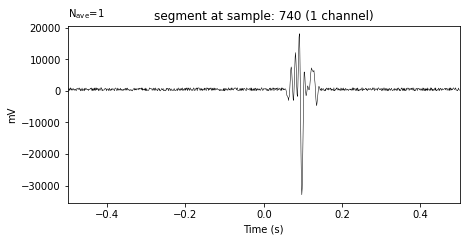

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


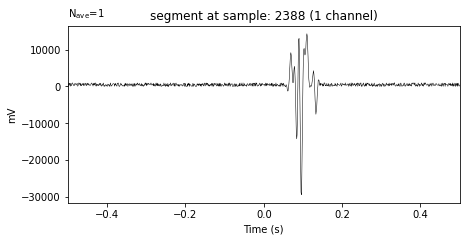

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


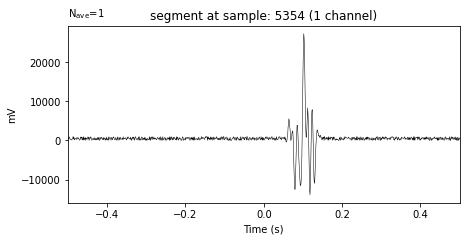

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


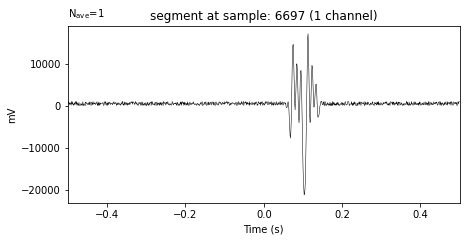

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


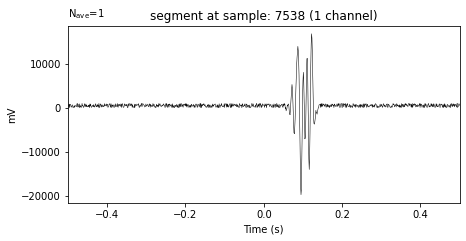

========= type: 1 ===========
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


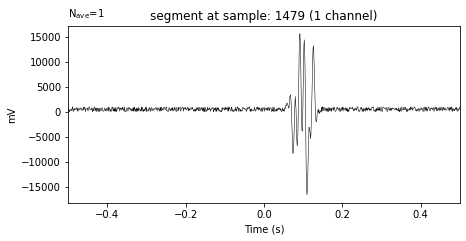

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


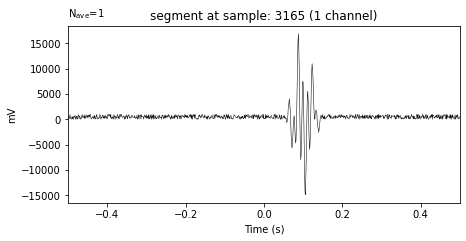

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


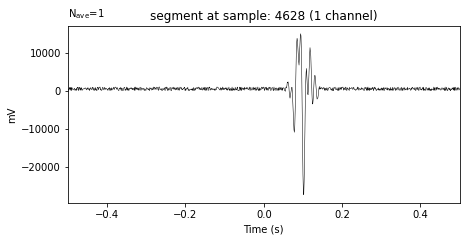

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


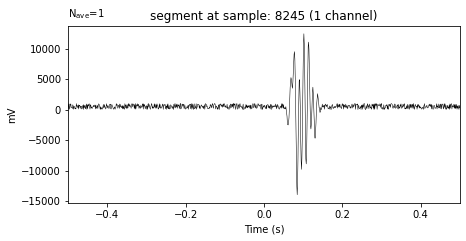

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


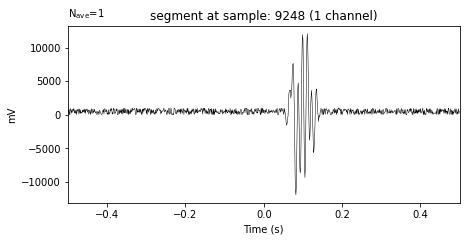

In [28]:
#@title Printing original segments {display-mode: "form"}
print('ampltiude, freq, phase:')
print(sin_parameters)
print('inserted waves:')
pprint(inserted_waves)

# 原始片段
print('================================')
print('= Printing Oringinal Segments: =')
print('================================')
print()
sep_original_events=[]
# 同频事件：聚出来的频率类分成不同的 event_id，包装到 events 里面。
for key in inserted_waves.keys():
    original_events = np.zeros((len(inserted_waves[key]), 3), dtype=int)
    original_events[:, 0] = np.array(inserted_waves[key])*sfreq
    original_events[:, 2] = key
    print(original_events)
    sep_original_events.append(original_events)

for index,original_events in enumerate(sep_original_events):
    print(f'========= type: {index} ===========')
    for ievent in original_events:
        print_sample(ievent[0])


## Clustering inside same freq

In [29]:
# freqs_times=np.array([[3,4,5,13.3],
            #  [9,10,11,13.2],[6,7,8,13.1],[13,15,17,18],[18,17,20,19]])*sfreq  # 单位 s

# freqs_times=np.array([[3,4,5,13],
#              [9,10,11,13],[6,7,8,13],[13,15,17,18],[18,19.1,20,19]])*sfreq  # 单位 s

# type_id=[0,1,2,3,4]
# type_freq_range=[[40,45],[50,60],[60,80],[10,25],[26,27]]  # 单位 Hz


# for index, (center,lab) in enumerate(zip(Muk,np.unique(C_i))):
#     # print('---------------------------------')
#     print(f'--------  label = {lab}  --------')
#     for original_index, point in enumerate(ans['source']):
#         if C_i[original_index] == lab:
#             print('label =',lab,', sample location:',ans['ievents'][original_index][0], ',' , ans['ievents'][original_index][0]/sfreq,'s,', 'segment_head:', point[:3],'original_index:', original_index)
#             print_sample(ans['ievents'][original_index][0])

#@title Aggregate Same Frequency Events  {display-mode: "form"}
#@title 同频事件 {display-mode: "form"}

sep_freq_events=[]
# 同频事件：聚出来的频率类分成不同的 event_id，包装到 events 里面。
for (i,lab) in enumerate(type_id):
    # print(freqs_times[i])
    freq_events = np.zeros((len(freqs_times[i]), 3), dtype=int)
    freq_events[:, 0] = freqs_times[i]
    freq_events[:, 2] = type_id[i]
    # print(freq_events)
    if i==0:
        long_events=freq_events.copy()
    else:
        long_events=np.vstack((long_events,freq_events))
    # print(long_events)
    sep_freq_events.append(freq_events)

# print(sep_freq_events)
# print(long_events)
# epochs = Epochs(raw, long_events,tmin=tmin, tmax=tmax,baseline=None)


In [ ]:
#@title Clustering Waves Events inside Same Frequency with bandpass {display-mode: "form"}

#@title 同频内波形继续分类 {display-mode: "form"}

# 波形分类：对每个同频率的 events 里面进行（滤波）聚类。
for ievents,irange in zip(sep_freq_events,type_freq_range):
  # iepochs = Epochs(raw, ievents, ievents[0][2], tmin=tmin, tmax=tmax,baseline=None)
  # print(iepochs)
  # iepochs.get_data()[:,0]
  # source=iepochs.get_data()[:,0]
  # print(iepochs)
  # ans=clustering(ievents,var_from_name(algorithm))
#   p=pipeline([])
    print()
    print('======================================================')
    print(f'->>> Start Clustering for freq range: {irange} ')
    print(f'->>> Sample Numbers: {len(ievents)}')
    print('======================================================')
    print()
    if len(ievents)<=2:
        continue

    # p=pipeline([zscore,downsample(6)]) 
    # ans=clustering(ievents,algorithm,p)
    # plot_clusters(ans)
    # plot_p_clusters(ans)

    print('==========================================')
    print(f'***** performing bandpass filter {irange}*****')
    print('==========================================')
    p=pipeline([zscore,downsample(3),bandpass([irange[0],irange[1]])])
    ans=clustering(ievents,algorithm,p)
    plot_clusters(ans)
    plot_p_clusters(ans)



[[4716    0    0]
 [3264    0    0]
 [8333    0    0]
 [9329    0    0]
 [ 841    0    0]
 [2491    0    0]
 [5446    0    0]
 [8333    0    1]
 [3273    0    1]
 [9347    0    1]
 [1580    0    1]
 [4725    0    1]
 [6795    0    2]
 [7637    0    2]]

->>> Start Clustering for All Events: [53.825065274151434, 63.825065274151434] 
->>> Sample Numbers: 14

Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 7 events and 1001 original time points ...
0 bad epochs dropped


<ipython-input-24-f26b068fed65>:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = Epochs(raw, ievents, ievents[0][2], tmin=tmin, tmax=tmax,baseline=None)


y_pre: [1 1 0 0 1 0 1]
score: 0.04492176423486837
y_pre: [1 2 2 2 1 1 0]
score: 0.17051608805163157
y_pre: [0 2 2 2 3 0 1]
score: 0.10406199070993294
y_pre: [1 0 2 2 3 1 4]
score: 0.12124232314380874
y_pre: [1 3 2 5 4 1 0]
score: 0.06887603948518742
best_score: 0.17051608805163157
best_model: TimeSeriesKMeans(max_iter=10, metric='dtw')
best_cluster_num: 3
****************************************
*** Ploting Clusters after pipeline : **
****************************************
==   Ploting Clusters :       ==
label = 0 , sample location: 5446 , 5.446 s, segment_head: [ 0.0016898  -0.16599924  0.1663403 ] original_index: 6
label = 1 , sample location: 4716 , 4.716 s, segment_head: [ 0.11849295 -0.04892936  0.13025081] original_index: 0
label = 1 , sample location: 841 , 0.841 s, segment_head: [ 0.00583993 -0.09913484 -0.136681  ] original_index: 4
label = 1 , sample location: 2491 , 2.491 s, segment_head: [-0.06321288 -0.17815879  0.18747901] original_index: 5
label = 2 , sample location

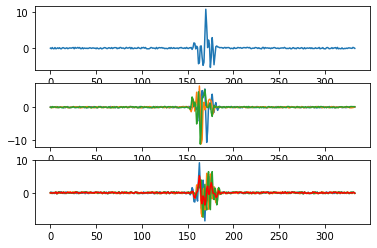

= Printing Oringinal Segments: =
--------  label = 0  --------
label = 0 , sample location: 5446 , 5.446 s, segment_head: [ 0.0016898  -0.16599924  0.1663403 ] original_index: 6
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


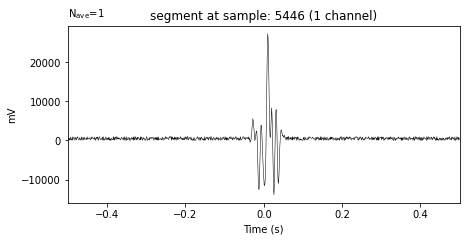

--------  label = 1  --------
label = 1 , sample location: 4716 , 4.716 s, segment_head: [ 0.11849295 -0.04892936  0.13025081] original_index: 0
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


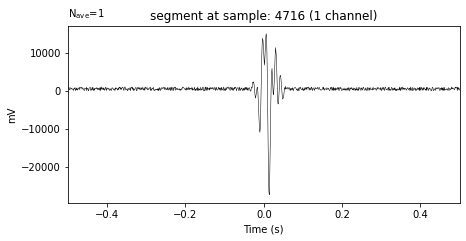

label = 1 , sample location: 841 , 0.841 s, segment_head: [ 0.00583993 -0.09913484 -0.136681  ] original_index: 4
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


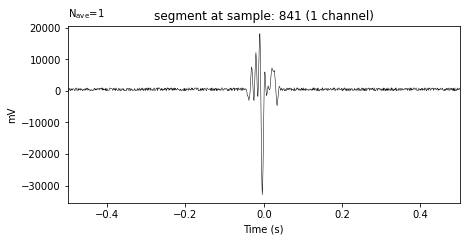

label = 1 , sample location: 2491 , 2.491 s, segment_head: [-0.06321288 -0.17815879  0.18747901] original_index: 5
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


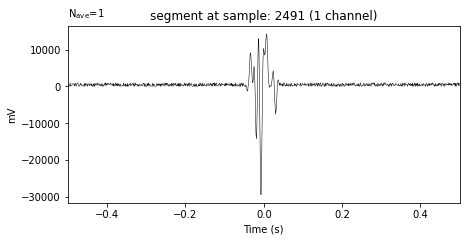

--------  label = 2  --------
label = 2 , sample location: 3264 , 3.264 s, segment_head: [-0.06779958  0.18849432  0.11345167] original_index: 1
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


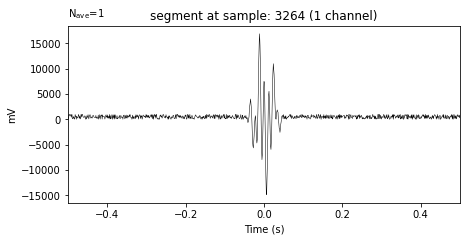

label = 2 , sample location: 8333 , 8.333 s, segment_head: [-0.16778964 -0.13914848 -0.02034034] original_index: 2
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


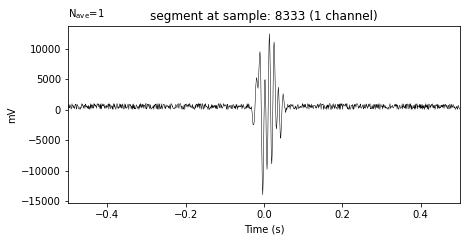

label = 2 , sample location: 9329 , 9.329 s, segment_head: [ 0.12423401 -0.15304367 -0.24371216] original_index: 3
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Need more than one channel to make topography for seeg. Disabling interactivity.


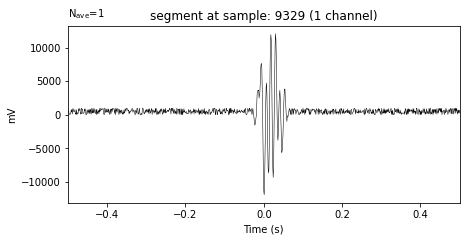

In [39]:
#@title Clustering Waves Events Directly by All {display-mode: "form"}
# 全部波形分类

print(long_events)
print()
print('======================================================')
print(f'->>> Start Clustering for All Events: {irange} ')
print(f'->>> Sample Numbers: {len(long_events)}')
print('======================================================')
print()
if len(long_events)>=2:
    # print('==========================================')
    # print(f'***** performing bandpass filter {irange}*****')
    # print('==========================================')
    # p=pipeline([zscore,downsample(3),bandpass([irange[0],irange[1]])])
    p=pipeline([zscore,downsample(3)])
    ans=clustering(long_events,algorithm,p)
    # plot_clusters(ans)
    plot_p_clusters(ans)

